## Getting started
Set working directory to top level of repo to ensure links work correctly:

In [1]:
cd ../..

/home/jovyan/Robbi/dea-intertidal


In [ ]:
# pip install -r requirements.in --quiet

### Load packages

In [2]:
%load_ext autoreload
%autoreload 2

import os
import dask
import numpy as np
import geopandas as gpd
from ipyleaflet import basemaps, basemap_to_tiles

import datacube
import odc.geo.xr
from odc.ui import select_on_a_map
from odc.geo.geom import Geometry
from odc.algo import (
    int_geomedian,
    keep_good_only,
)

from dea_tools.dask import create_local_dask_cluster
from dea_tools.coastal import pixel_tides

from intertidal.elevation import load_data

# Create local dask cluster to improve data load time
client = create_local_dask_cluster(return_client=True)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/8787/status,
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/8787/status,Workers: 1
Total threads: 31,Total memory: 237.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40747,Workers: 1
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/8787/status,Total threads: 31
Started: Just now,Total memory: 237.21 GiB
Comm: tcp://127.0.0.1:45665,Total threads: 31
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/34177/status,Memory: 237.21 GiB
Nanny: tcp://127.0.0.1:35125,


## Setup

### Set analysis parameters

In [3]:
# Intertidal Elevation variables
start_date = "2019"  # Start date for analysis
end_date = "2021"  # End date for analysis
threshold_lowtide = 0.2  # Quantile to determine low tide height threshold
threshold_hightide = 0.8  # Quantile to determine high tide height threshold
resolution = 10  # Spatial resolution used for output files
crs = "EPSG:3577"  # Coordinate Reference System (CRS) to use for output files
filter_gqa = False  # Filter to remove poorly georeferenced scenes?
tide_model = "FES2014"  # Tide model to use in analysis
tide_model_dir = "/var/share/tide_models"  # Directory containing tide model files


#### Set study area

##### Option 1: load study area from 32 km tile GridSpec

In [4]:
# Set study area (e.g. tile ID in form 'x143y87')
study_area = "x40y100"
geom = None  # Use GridSpec to load study area, not a custom geom

##### Option 2: load study area from vector file

In [ ]:
# # Set study area to load from file
# study_area = "pointstuart"

# # Read file, select study area and convert to geom
# studyarea_gdf = gpd.read_file(
#     "data/raw/intertidal_development_polygons.geojson"
# ).set_index("id")
# geom = Geometry(studyarea_gdf.loc[study_area].geometry, crs=studyarea_gdf.crs)
# geom

##### Option 3: load study area using interactive map

In [ ]:
# # Set study area name for outputs
# study_area = "testing"

# # Plot interactive map to select area
# basemap = basemap_to_tiles(basemaps.Esri.WorldImagery)
# geom = select_on_a_map(height="600px", layers=(basemap,), center=(-26, 135), zoom=4)
# geom

## Analysis

### Load data

In [5]:
# Connect to datacube to access data
dc = datacube.Datacube(app="Intertidal_composites")

satellite_ds = load_data(
    dc=dc,
    study_area=study_area,
    geom=geom,
    time_range=(start_date, end_date),
    resolution=resolution,
    crs=crs,
    include_s2=True,
    include_ls=False,
    filter_gqa=filter_gqa,
    ndwi=False,
    dtype="int16"
    # mask_sunglint=20,
)

satellite_ds

<xarray.Dataset>
Dimensions:           (time: 208, y: 3200, x: 3200)
Coordinates:
  * time              (time) datetime64[ns] 2019-01-02T02:23:19.175000 ... 20...
  * y                 (y) float64 -2.24e+06 -2.24e+06 ... -2.272e+06 -2.272e+06
  * x                 (x) float64 -1.408e+06 -1.408e+06 ... -1.376e+06
    spatial_ref       int32 3577
Data variables:
    nbart_blue        (time, y, x) int16 dask.array<chunksize=(1, 1600, 1600), meta=np.ndarray>
    nbart_green       (time, y, x) int16 dask.array<chunksize=(1, 1600, 1600), meta=np.ndarray>
    nbart_red         (time, y, x) int16 dask.array<chunksize=(1, 1600, 1600), meta=np.ndarray>
    nbart_red_edge_1  (time, y, x) int16 dask.array<chunksize=(1, 1600, 1600), meta=np.ndarray>
    nbart_red_edge_2  (time, y, x) int16 dask.array<chunksize=(1, 1600, 1600), meta=np.ndarray>
    nbart_red_edge_3  (time, y, x) int16 dask.array<chunksize=(1, 1600, 1600), meta=np.ndarray>
    nbart_nir_1       (time, y, x) int16 dask.array<chunksize=(1, 1600, 1600), meta=np.ndarray>
    nbart_nir_2       (time, y, x) int16 dask.array<chunksize=(1, 1600, 1600), meta=np.ndarray>
    nbart_swir_2      (time, y, x) int16 dask.array<chunksize=(1, 1600, 1600), meta=np.ndarray>
    nbart_swir_3      (time, y, x) int16 dask.array<chunksize=(1, 1600, 1600), meta=np.ndarray>
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

### Model tides and calculate tide height thresholds

TODO: Move this code into `pixel_tides` by allowing `.compute()` to be turned off and custom chunks specified

In [7]:
# Model tides into for spatial extent and timesteps in satellite data
tides_highres, tides_lowres = pixel_tides(
    satellite_ds,
    model=tide_model,
    directory=tide_model_dir,
    cutoff=np.inf,
    dask_compute=False,
)

# Start processing tide data, using .persist so we can re-use our results
tides_highres.persist()

Creating reduced resolution 5000 x 5000 metre tide modelling array
Modelling tides using FES2014 in parallel


100%|██████████| 5/5 [00:07<00:00,  1.52s/it]

Reprojecting tides into original array


<xarray.DataArray 'tide_m' (time: 208, y: 3200, x: 3200)>
dask.array<reproject, shape=(208, 3200, 3200), dtype=float32, chunksize=(1, 1600, 1600), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 2019-01-02T02:23:19.175000 ... 2021-12...
    tide_model   <U7 'FES2014'
    spatial_ref  int32 3577
  * y            (y) float64 -2.24e+06 -2.24e+06 ... -2.272e+06 -2.272e+06
  * x            (x) float64 -1.408e+06 -1.408e+06 ... -1.376e+06 -1.376e+06

In [8]:
# Calculate low and high tide height thresholds using quantile of
# all tide observations.
threshold_ds = (
    tides_lowres.quantile(q=[threshold_lowtide, threshold_hightide], dim="time")
    .odc.assign_crs(satellite_ds.odc.geobox.crs)
    .odc.reproject(satellite_ds.odc.geobox, resampling="bilinear")
    .drop("quantile")
)


### Create low and high tide subsets

In [9]:
# Apply threshold to keep only pixels with tides less or greater than
# than tide height threshold
low_mask = tides_highres <= threshold_ds.isel(quantile=0)
high_mask = tides_highres >= threshold_ds.isel(quantile=-1)

# Mask out pixels outside of selected tides. Drop fully empty scenes
# to speed up geomedian
ds_low = keep_good_only(x=satellite_ds, where=low_mask).sel(
    time=low_mask.any(dim=["x", "y"])
)
ds_high = keep_good_only(x=satellite_ds, where=high_mask).sel(
    time=high_mask.any(dim=["x", "y"])
)

### Compute geomedians with Dask

In [10]:
# Calculate low and high tide geomedians
num_threads = os.cpu_count() - 2
ds_lowtide = int_geomedian(ds=ds_low, maxiters=10, num_threads=num_threads)
ds_hightide = int_geomedian(ds=ds_high, maxiters=10, num_threads=num_threads)

# Load into memory and close client
ds_lowtide.load()
ds_hightide.load()

# Close Dask client
client.close()

/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


### Plot outputs

/env/lib/python3.8/site-packages/odc/geo/_xr_interop.py:320: UserWarning: grid_mapping=spatial_ref is not pointing to valid coordinate
  warnings.warn(


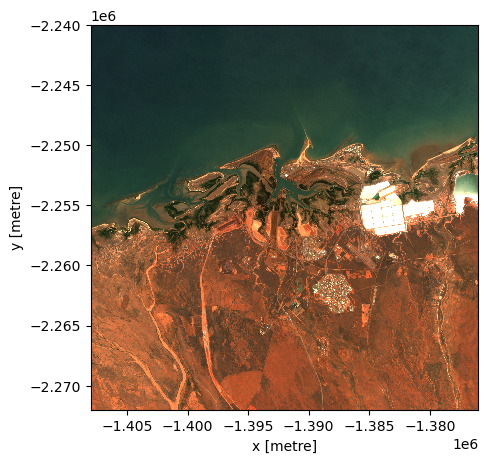

In [11]:
ds_lowtide.odc.to_rgba(
    bands=["nbart_red", "nbart_green", "nbart_blue"], vmin=100, vmax=2300
).plot.imshow(size=5, aspect=1)

/env/lib/python3.8/site-packages/odc/geo/_xr_interop.py:320: UserWarning: grid_mapping=spatial_ref is not pointing to valid coordinate
  warnings.warn(


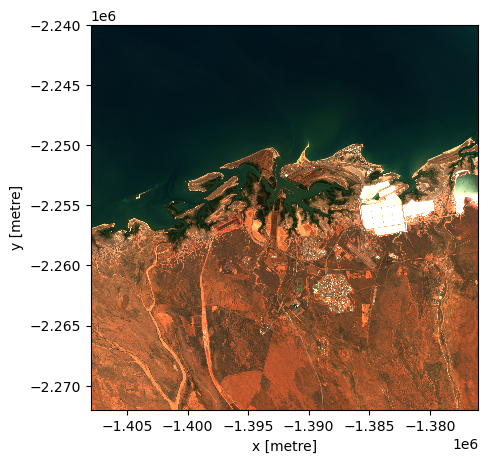

In [12]:
ds_hightide.odc.to_rgba(
    bands=["nbart_red", "nbart_green", "nbart_blue"], vmin=100, vmax=2300
).plot.imshow(size=5, aspect=1)

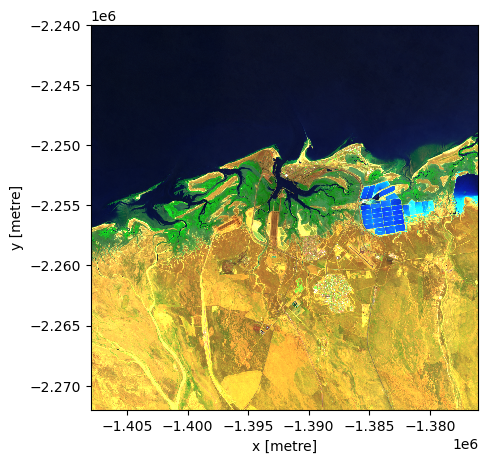

In [13]:
ds_lowtide.odc.to_rgba(
    bands=["nbart_swir_3", "nbart_nir_1", "nbart_green"], vmin=100, vmax=3000
).plot.imshow(size=5, aspect=1)

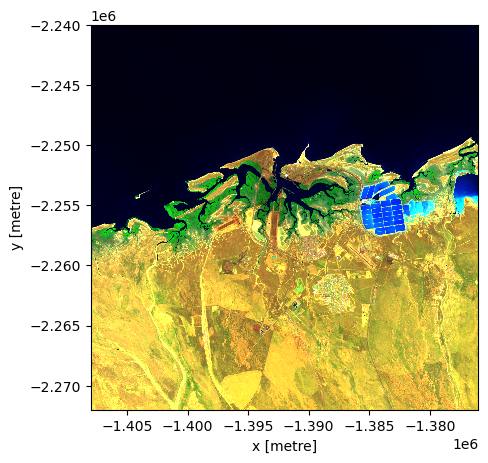

In [14]:
ds_hightide.odc.to_rgba(
    bands=["nbart_swir_3", "nbart_nir_1", "nbart_green"], vmin=100, vmax=3000
).plot.imshow(size=5, aspect=1)

## Export layers

In [15]:
# Create output folder. If it doesn't exist, create it
output_dir = f"data/interim/{study_area}/{start_date}-{end_date}"
os.makedirs(output_dir, exist_ok=True)

In [16]:
prefix = f"{output_dir}/{study_area}_{start_date}_{end_date}"
ds_lowtide.to_array().odc.write_cog(
            f"{prefix}_composite_lowtide_{int(threshold_lowtide * 100)}.tif",
            overwrite=True,
        )
ds_hightide.to_array().odc.write_cog(
            f"{prefix}_composite_hightide_{int(threshold_hightide * 100)}.tif",
            overwrite=True,
        )

/env/lib/python3.8/site-packages/odc/geo/_xr_interop.py:320: UserWarning: grid_mapping=spatial_ref is not pointing to valid coordinate
  warnings.warn(
/env/lib/python3.8/site-packages/odc/geo/_xr_interop.py:320: UserWarning: grid_mapping=spatial_ref is not pointing to valid coordinate
  warnings.warn(


PosixPath('data/interim/x40y100/2019-2021/x40y100_2019_2021_composite_hightide_80.tif')